In [1]:
!pip install scikit-learn
!pip install tensorflow
!pip install librosa
!pip install keras

In [2]:
# import the required libraries

import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Extract Mel Spectrogram

def extract_mel_spectrogram(file_path, max_pad_len=128):
    try:
        y, sr = librosa.load(file_path, sr=16000, duration=5.0)
        mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mels_db = librosa.power_to_db(mels, ref=np.max)

        if mels_db.shape[1] < max_pad_len:
            pad_width = max_pad_len - mels_db.shape[1]
            mels_db = np.pad(mels_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mels_db = mels_db[:, :max_pad_len]

        return mels_db
    except:
        return None

In [4]:
#Load Dataset

import os

DATASET_PATH = r"C:\Users\KIIT0001\OneDrive\Desktop\Deep Fake audio detection\audio dataset"
real_path = os.path.join(DATASET_PATH, 'real')
fake_path = os.path.join(DATASET_PATH, 'fake')

In [5]:
X = []
y = []

for label, folder in [("real", real_path), ("fake", fake_path)]:
    for file in tqdm(os.listdir(folder)):
        file_path = os.path.join(folder, file)
        mel = extract_mel_spectrogram(file_path)
        if mel is not None:
            X.append(mel)
            y.append(label)

X = np.array(X)
X = X[..., np.newaxis]  # (samples, 128, 128, 1)


100%|██████████| 5/5 [00:00<00:00, 62.08it/s]


In [6]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

In [7]:
#Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y_cat)

In [8]:
#Build CNN Model

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,002 (28.20 MB)

 Trainable params: 7,392,002 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the Model
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 7.5886 - val_accuracy: 0.5000 - val_loss: 20.3799
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6250 - loss: 43.8076 - val_accuracy: 0.5000 - val_loss: 75.8602
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.5000 - loss: 159.6462 - val_accuracy: 0.5000 - val_loss: 17.3727
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.5000 - loss: 88.3150 - val_accuracy: 0.5000 - val_loss: 12.2457
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.5000 - loss: 46.8953 - val_accuracy: 0.5000 - val_loss: 21.6735
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.5000 - loss: 35.6432 - val_accuracy: 0.5000 - val_loss: 17.7905
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5000 - loss: 20.9629 - val_accuracy: 0.5000 - val_loss: 8.1350
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7500 - loss: 1.7665 - val_accuracy: 0.0000e+

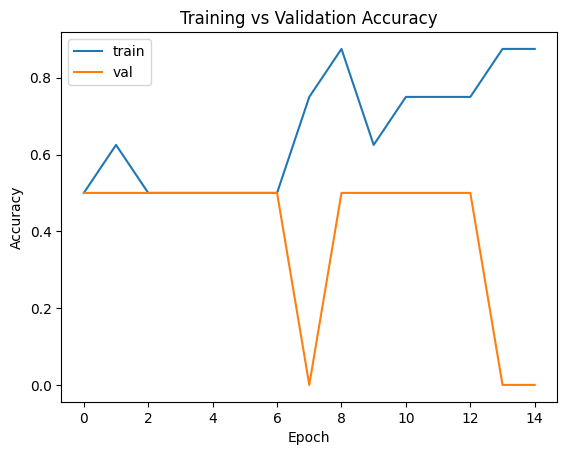

In [11]:
# plotting training history

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

In [12]:
#Save the Model

model.save("deepfake_model.h5")
print("Model saved as deepfake_model.h5")

Model saved as deepfake_model.h5


In [13]:
# Evaluate metrices

loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.0000e+00 - loss: 1.1757
Test Accuracy: 0.00%


In [14]:
import sounddevice as sd

In [15]:
# Real-Time Audio Recording

def record_audio(duration=5, sr=16000):
    print(" Recording started (Speak now)...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype='float32')
    sd.wait()
    print(" Recording complete.")
    return audio.flatten(), sr

In [16]:
# Convert to Spectrogram

def preprocess_audio(y, sr, max_pad_len=128):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    if mel_db.shape[1] < max_pad_len:
        pad_width = max_pad_len - mel_db.shape[1]
        mel_db = np.pad(mel_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :max_pad_len]

    mel_db = mel_db[np.newaxis, ..., np.newaxis]  # Shape: (1, 128, 128, 1)
    return mel_db

In [17]:
# Live Prediction

def predict_live_audio(model):
    y, sr = record_audio(duration=5)
    processed = preprocess_audio(y, sr)
    prediction = model.predict(processed)
    label = np.argmax(prediction)
    confidence = prediction[0][label]

    if label == 0:
        print(f" Predicted: Real Voice ({confidence:.2f})")
    else:
        print(f" Predicted: Fake Voice ({confidence:.2f})")

In [19]:
from tensorflow.keras.models import load_model
print("\n Now testing real-time voice...")
model = load_model("deepfake_model.h5")
predict_live_audio(model)


 Now testing real-time voice...
 Recording started (Speak now)...
 Recording complete.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
 Predicted: Fake Voice (0.50)


In [21]:
!pip install gradio 

In [22]:
import gradio as gr
import numpy as np
import librosa
from tensorflow.keras.models import load_model
import soundfile as sf
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Load your trained model

model = load_model("deepfake_model.h5")

In [24]:
# Preprocessing function (same as training)

def preprocess_audio(audio):
    y, sr = sf.read(audio)
    if len(y.shape) > 1:  # Stereo to mono
        y = y.mean(axis=1)
    y = librosa.resample(y, orig_sr=sr, target_sr=16000)
    mel = librosa.feature.melspectrogram(y=y, sr=16000, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Pad or trim to fixed shape
    if mel_db.shape[1] < 128:
        pad = 128 - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0, 0), (0, pad)), mode='constant')
    else:
        mel_db = mel_db[:, :128]

    return mel_db[np.newaxis, ..., np.newaxis]

In [25]:
#Define the Prediction Function

def predict_deepfake(audio):
    features = preprocess_audio(audio)
    prediction = model.predict(features)[0]
    label = "Real Voice 🟢" if np.argmax(prediction) == 0 else "Fake Voice 🔴"
    confidence = round(np.max(prediction) * 100, 2)
    return f"{label} (Confidence: {confidence}%)"

In [ ]:
#Launch the Gradio Interface

gr.Interface(
    fn=predict_deepfake,
    inputs=gr.Audio(sources="microphone", type="filepath", label="🎙️ Speak Your Voice"),
    outputs=gr.Textbox(label="Prediction"),
    live=True,
    title="Deepfake Audio Detection",
    description="Speak into your mic and detect if it's real or AI-generated."
).launch()

* Running on local URL:  http://127.0.0.1:7868
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Traceback (most recent call last):
  File "c:\Users\KIIT0001\anaconda3\envs\tf_env\lib\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
  File "c:\Users\KIIT0001\anaconda3\envs\tf_env\lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
  File "c:\Users\KIIT0001\anaconda3\envs\tf_env\lib\site-packages\gradio\blocks.py", line 2220, in process_api
    result = await self.call_function(
  File "c:\Users\KIIT0001\anaconda3\envs\tf_env\lib\site-packages\gradio\blocks.py", line 1731, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "c:\Users\KIIT0001\anaconda3\envs\tf_env\lib\site-packages\anyio\to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
  File "c:\Users\KIIT0001\anaconda3\envs\tf_env\lib\site-packages\anyio\_backends\_asyncio.py", line 2470, in run_sync_in_worker_t

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Traceback (most recent call last):
  File "c:\Users\KIIT0001\anaconda3\envs\tf_env\lib\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
  File "c:\Users\KIIT0001\anaconda3\envs\tf_env\lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
  File "c:\Users\KIIT0001\anaconda3\envs\tf_env\lib\site-packages\gradio\blocks.py", line 2220, in process_api
    result = await self.call_function(
  File "c:\Users\KIIT0001\anaconda3\envs\tf_env\lib\site-packages\gradio\blocks.py", line 1731, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "c:\Users\KIIT0001\anaconda3\envs\tf_env\lib\site-packages\anyio\to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
  File "c:\Users\KIIT0001\anaconda3\envs\tf_env\lib\site-packages\anyio\_backends\_asyncio.py", line 2470, in run_sync_in_worker_t